<H2>librarys installieren</H2>

In [26]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa

In [2]:
DATA_PATH = "data_gtzan_mfcc.json"

<H1>Daten laden</H1>

In [3]:
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)

    #konvertiere list in numpy array
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

<H1>Train/ Test Split und Validierungsdaten</H1>

In [4]:
def prepare_datasets(test_size, validation_size):
    #daten laden
    X, y = load_data(DATA_PATH)
    
    #train/test split
    X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=test_size, random_state=42)

    #train/ validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=42)

    # 3d array --> (130, 13, channel [1])
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [5]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

In [6]:
print(X_train.shape)
print(X_validation.shape)

(5993, 130, 13, 1)
(1499, 130, 13, 1)


<H1>Netzwerk Architektur</H1>

In [7]:
def build_model(input_shape):

    #CNN Model
    model = keras.Sequential()

    #Convolutional Layer 1
    model.add(keras.layers.Conv2D(32, (3,3),activation ="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))
    model.add(keras.layers.BatchNormalization())

    #Convolutional Layer 2
    model.add(keras.layers.Conv2D(32, (3,3),activation ="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))
    model.add(keras.layers.BatchNormalization())

    #Convolutional Layer 2
    model.add(keras.layers.Conv2D(32, (2,2),activation ="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding="same"))
    model.add(keras.layers.BatchNormalization())

    #flatten
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.25))

    #Output Layer
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model

In [8]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-14 23:02:29.702246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13294 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:65:00.0, compute capability: 8.6


<H1>Compile Netzwerk</H1>

In [9]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 4, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 1, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,514 (177.79 KB)

 Trainable params: 45,322 (177.04 KB)

 Non-trainable params: 192 (768.00 B)

<H1>Train Netzwerk</H1>

In [10]:
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30, callbacks=[early])

Epoch 1/30


I0000 00:00:1768431752.409326   41322 service.cc:146] XLA service 0x7fc95c003fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768431752.409373   41322 service.cc:154]   StreamExecutor device (0): NVIDIA A16, Compute Capability 8.6
2026-01-14 23:02:32.507103: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-14 23:02:32.745848: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2026-01-14 23:02:32.948069: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 41/188 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1110 - loss: 2.8952

I0000 00:00:1768431756.491101   41322 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.1600 - loss: 2.6331 - val_accuracy: 0.3142 - val_loss: 1.9178
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3405 - loss: 1.9119 - val_accuracy: 0.4343 - val_loss: 1.6038
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4102 - loss: 1.6711 - val_accuracy: 0.4730 - val_loss: 1.4611
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4674 - loss: 1.5209 - val_accuracy: 0.4990 - val_loss: 1.3662
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4937 - loss: 1.4296 - val_accuracy: 0.5404 - val_loss: 1.2839
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5361 - loss: 1.3213 - val_accuracy: 0.5564 - val_loss: 1.2371
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5447 - loss: 1.2908 - val_accuracy: 0.5664 - val_loss: 1.1913
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5574 - loss: 1.2483 - val_accuracy: 0.5891 - va

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Accuracy auf Testset ist: {}".format(test_accuracy))

79/79 - 1s - 12ms/step - accuracy: 0.7054 - loss: 0.8168
Accuracy auf Testset ist: 0.7053642868995667


In [12]:
def plot_history(history):
    
    plt.figure(figsize=(14, 6))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Loss über Epochen')
    plt.xlabel('Epochen (Iterationen über Daten)')
    plt.ylabel('Loss (Sparse Categorical Crossentropy)')
    plt.legend()
    plt.grid(True)
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Accuracy über Epochen')
    plt.xlabel('Epochen (Iterationen über Daten)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


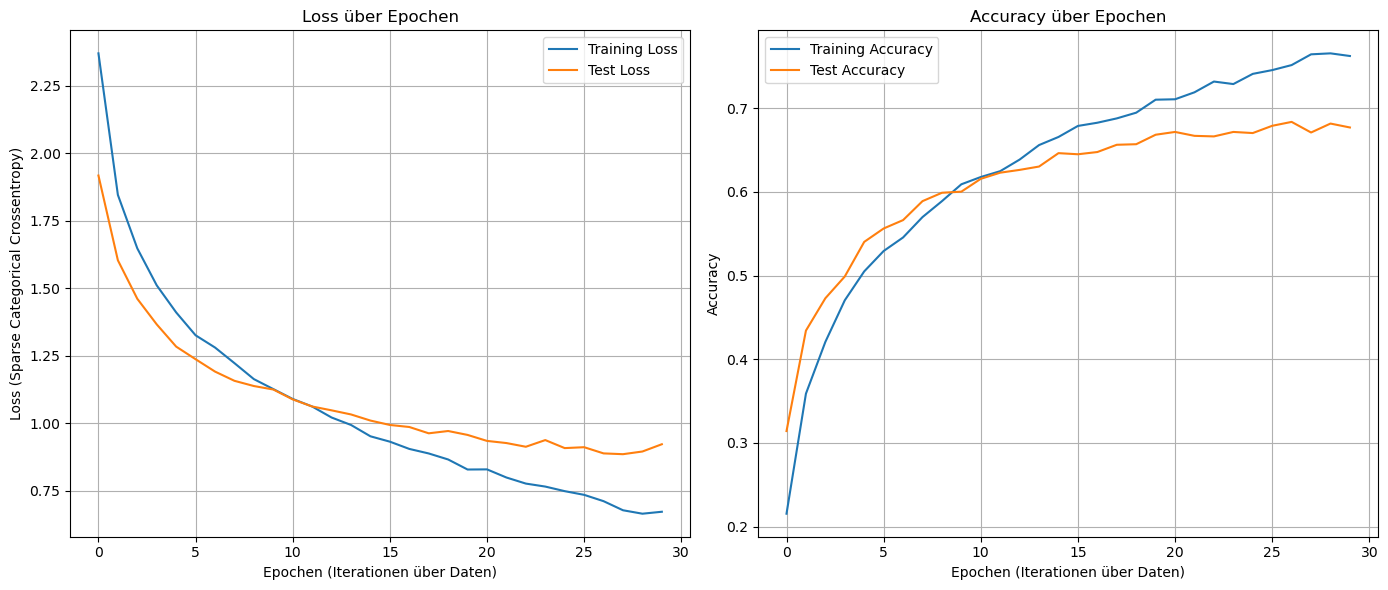

In [13]:
plot_history(history)

In [14]:
def load_mapping(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
    return data["mapping"]

In [15]:
def evaluate_model(
    model,
    X,
    y,
    class_names,
    model_name="Model",
    normalize=True,
    show_report=True
):
    """
    Evaluate a classification model with confusion matrices and optional report.

    Parameters
    ----------
    model : tf.keras.Model
        Trained Keras model.
    X : np.ndarray
        Input data (e.g. X_test).
    y : np.ndarray
        True labels.
    class_names : list[str]
        List of class/genre names in correct label order.
    model_name : str
        Name of the model (used in plot titles).
    normalize : bool
        Whether to show a normalized confusion matrix.
    show_report : bool
        Whether to print classification report.
    """

    # Predictions
    y_prob = model.predict(X, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    # ---------- Confusion Matrix (Counts)
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )
    disp.plot(
        xticks_rotation=90,
        values_format="d",
        cmap=None
    )
    plt.title(f"{model_name} – Confusion Matrix (Counts)")
    plt.tight_layout()
    plt.show()

    # ---------- Confusion Matrix (Normalized per true class)
    if normalize:
        cm_norm = confusion_matrix(y, y_pred, normalize="true")

        plt.figure(figsize=(10, 8))
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm_norm,
            display_labels=class_names
        )
        disp.plot(
            xticks_rotation=90,
            values_format=".2f",
            cmap=None
        )
        plt.title(f"{model_name} – Confusion Matrix (Normalized)")
        plt.tight_layout()
        plt.show()

    # ---------- Classification report
    if show_report:
        print(f"\nClassification Report – {model_name}")
        print(
            classification_report(
                y,
                y_pred,
                target_names=class_names,
                digits=3
            )
        )

    return y_pred


<Figure size 1000x800 with 0 Axes>

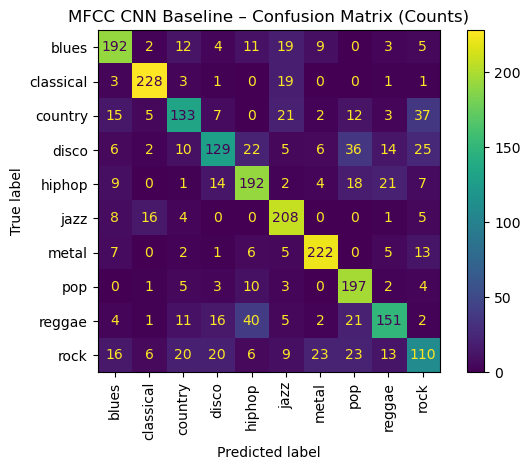

<Figure size 1000x800 with 0 Axes>

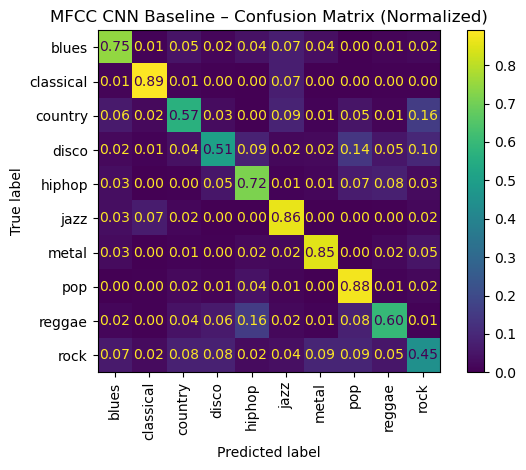


Classification Report – MFCC CNN Baseline
              precision    recall  f1-score   support

       blues      0.738     0.747     0.743       257
   classical      0.874     0.891     0.882       256
     country      0.662     0.566     0.610       235
       disco      0.662     0.506     0.573       255
      hiphop      0.669     0.716     0.692       268
        jazz      0.703     0.860     0.773       242
       metal      0.828     0.851     0.839       261
         pop      0.642     0.876     0.741       225
      reggae      0.706     0.597     0.647       253
        rock      0.526     0.447     0.484       246

    accuracy                          0.705      2498
   macro avg      0.701     0.706     0.698      2498
weighted avg      0.703     0.705     0.699      2498



array([0, 5, 0, ..., 7, 7, 7])

In [16]:
class_names = load_mapping(DATA_PATH)

evaluate_model(
    model=model,
    X=X_test,
    y=y_test,
    class_names=class_names,
    model_name="MFCC CNN Baseline"
)


In [17]:
# X_train hat (N,130,13,1) -> kanal entfernen
X_train_3d = X_train[..., 0]  # (N,130,13)
X_val_3d   = X_validation[..., 0]
X_test_3d  = X_test[..., 0]

In [18]:
print(X_train_3d.shape)
print(X_val_3d.shape)
print(X_test_3d.shape)

(5993, 130, 13)
(1499, 130, 13)
(2498, 130, 13)


In [19]:
def add_deltas(X):
    """
    Add delta and delta-delta features to MFCCs.

    Parameters
    ----------
    X : np.ndarray
        Shape (N, T, 13) – MFCC features without channel dimension.

    Returns
    -------
    np.ndarray
        Shape (N, T, 13, 3) – MFCC, delta, delta-delta stacked as channels.
    """
    X_out = []

    for x in X:
        # x: (T, 13)
        mfcc = x.T  # (13, T)

        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)

        # Stack channels -> (13, T, 3)
        stacked = np.stack([mfcc, delta, delta2], axis=-1)

        # Back to (T, 13, 3)
        X_out.append(stacked.transpose(1, 0, 2))

    return np.array(X_out, dtype=np.float32)


In [22]:
X_train_3d = add_deltas(X_train_3d)
X_val_3d = add_deltas(X_val_3d)
X_test_3d = add_deltas(X_test_3d)

print(X_train_3d.shape, X_val_3d.shape, X_test_3d.shape)  # (..,130,13,3)

(5993, 130, 13, 3) (1499, 130, 13, 3) (2498, 130, 13, 3)


In [27]:
input_shape_3d = (X_train_3d.shape[1], X_train_3d.shape[2], X_train_3d.shape[3]) 
model_3d = build_model(input_shape_3d)

#compile 3d Modell
#optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_3d.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_3d.summary()

history_3d = model_3d.fit(X_train_3d, y_train, validation_data=(X_val_3d, y_validation), batch_size=32, epochs=30, callbacks=[early])

/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 128, 11, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 62, 4, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 31, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 30, 1, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 15, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,736 (534.13 KB)

 Trainable params: 45,898 (179.29 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 90,646 (354.09 KB)

Epoch 1/30


NotImplementedError: numpy() is only available when eager execution is enabled.

In [ ]:
plot_history(history_3d)

In [28]:
import tensorflow as tf
print("Eager:", tf.executing_eagerly())
print("TF version:", tf.__version__)


Eager: True
TF version: 2.17.1


In [29]:
import numpy as np
import tensorflow as tf

def inspect(name, arr):
    print(f"\n{name}:")
    print("  type:", type(arr))
    if isinstance(arr, np.ndarray):
        print("  dtype:", arr.dtype)
        print("  shape:", arr.shape)
        print("  is_object_dtype:", arr.dtype == object)
        print("  min/max:", np.min(arr), np.max(arr))
    else:
        try:
            print("  tf dtype:", arr.dtype)
            print("  tf shape:", arr.shape)
        except Exception as e:
            print("  cannot inspect:", e)

inspect("X_train_3d", X_train_3d)
inspect("X_val_3d", X_val_3d)
inspect("y_train", y_train)
inspect("y_validation", y_validation)
print("\nEager:", tf.executing_eagerly())



X_train_3d:
  type: <class 'numpy.ndarray'>
  dtype: float32
  shape: (5993, 130, 13, 3)
  is_object_dtype: False
  min/max: -756.4425 276.89398

X_val_3d:
  type: <class 'numpy.ndarray'>
  dtype: float32
  shape: (1499, 130, 13, 3)
  is_object_dtype: False
  min/max: -691.5859 257.17426

y_train:
  type: <class 'numpy.ndarray'>
  dtype: int64
  shape: (5993,)
  is_object_dtype: False
  min/max: 0 9

y_validation:
  type: <class 'numpy.ndarray'>
  dtype: int64
  shape: (1499,)
  is_object_dtype: False
  min/max: 0 9

Eager: True
